# **Transfer-Learning Using mobilenetv2**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf

import glob, os, random

Load dataset from kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets download -d asdasdasasdas/garbage-classification
!unzip -q garbage-classification.zip -d .
!ls 'garbage classification'

 87% 71.0M/82.0M [00:00<00:00, 61.1MB/s]
100% 82.0M/82.0M [00:00<00:00, 93.1MB/s]
'Garbage classification'


Check datasets

In [5]:
base_path = './garbage classification/Garbage classification'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


Load Pre-trained model (MobileNetv2)

In [6]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [7]:
import tensorflow_hub as hub
do_fine_tuning = True #@param {type:"boolean"}

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

Img generator setup

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=25,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=25,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)
print(len(labels))

Found 2527 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}
6


In [9]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 2,587,462
Trainable params: 2,553,350
Non-trainable params: 34,112
_________________________________________________________________


Fine-tune checks

In [10]:
if do_fine_tuning:
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9)
    feature_extractor.trainable = True
else: 
    feature_extractor.trainable = False
    optimizer = "adam"

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Train

In [11]:
history = model.fit(train_generator, epochs=75, steps_per_epoch=25, validation_data = validation_generator, verbose = 1, validation_steps=5)
model.save("model.h5")

Epoch 1/75
25/25 [==============================] - 46s 377ms/step - loss: 2.1272 - accuracy: 0.3840 - val_loss: 1.7465 - val_accuracy: 0.5680
Epoch 2/75
25/25 [==============================] - 9s 363ms/step - loss: 1.5105 - accuracy: 0.6464 - val_loss: 1.7647 - val_accuracy: 0.5680
Epoch 3/75
25/25 [==============================] - 9s 357ms/step - loss: 1.2615 - accuracy: 0.7296 - val_loss: 1.5637 - val_accuracy: 0.6240
Epoch 4/75
25/25 [==============================] - 9s 356ms/step - loss: 1.1772 - accuracy: 0.7696 - val_loss: 1.1007 - val_accuracy: 0.8000
Epoch 5/75
25/25 [==============================] - 9s 360ms/step - loss: 1.0877 - accuracy: 0.7936 - val_loss: 1.0614 - val_accuracy: 0.7840
Epoch 6/75
25/25 [==============================] - 9s 363ms/step - loss: 0.9800 - accuracy: 0.8304 - val_loss: 0.8969 - val_accuracy: 0.8400
Epoch 7/75
25/25 [==============================] - 9s 360ms/step - loss: 0.9735 - accuracy: 0.8416 - val_loss: 0.8880 - val_accuracy: 0.8640
Epoch

Plot Acc and losses

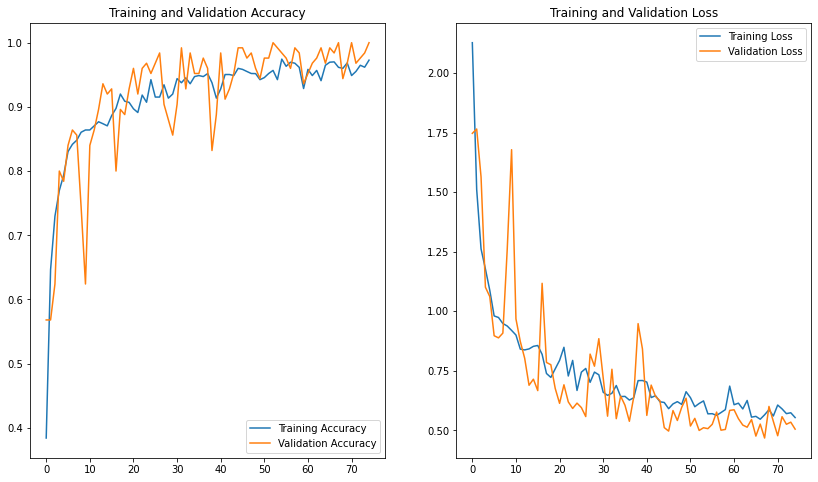

In [12]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs_range   = range(len(acc))
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Score

In [15]:
score = model.evaluate(train_generator, return_dict=True, verbose=0)

print(score)

{'loss': 0.5349137187004089, 'accuracy': 0.9722991585731506}
